# Clustering

We now know how to multiply matrices, let's practice tensor manipulation in this 02_meanshift notebook.
The goal is the homework, to get to a point where we can implement something like this but for a different algorithm. 
Tensor manipulation is like learning the times table, it comes up all the time.
If we're not good at it, the rest gets difficult, we get slower,
and it's frustrating to spend time thinking about the mechanical operations rather than getting work done.
<br>
When we have  an idea it is key to quickly translate it into working code.
Code for GPUs and fast running CPUs is using broadcasting, Einstein notation, matrix modifications, etc.
So this is important. 
We're going to practice it by developing a clustering algorithm, *mean shift clustering*,
a fun algorithm that few come across, and it is useful. 
<br>
Cluster analysis is different to anything that we've worked on in this course so far.
There isn't a dependent variable that we're trying to match. 
Instead we're trying to find "clusters", groups of similar things in the data.
There are many different areas with applications of cluster analysis. 
Sometimes cluster analysis can be overused or misused. 
It's best for when the various columns are the same kind of thing and have the same kind of scale. 
For example, pixels are all the same kind of thing.  
But for market research with socio-demographic inputs may not be as good because they're different kinds of things. 
An OK example is data from surveys, e.g., with from one to five answers.

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself.
To demonstrate how clustering works lets generate some data and show clustering in action. 

In [1]:
import torch
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data (synthetic)
We create some some synthetic data which we know how we want it to behave.
Lets create six clusters, each is going to have a random < 1000 samples in it. 
First we randomly create six centroids, the "middle" of where the clusters are. 

In [2]:
n_clusters=6

In [3]:
from random import sample
#n_samples=[250,300,75,125,500,400] # this is needed to have clusters of different size
n_samples = sample(range(1, 1000), n_clusters)
assert n_clusters==len(n_samples)
total_samples = sum(n_samples)
total_samples, n_samples

(4029, [708, 903, 501, 832, 600, 485])

First we randomly create six centroids, the "middle" of where the clusters are. 
We need them n_clusters by 2 because we need an X and a Y coordinate for each one. 

In [32]:
centroids = torch.randint(-35, 35, (n_clusters, 2)).float()

#centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

Now we randomly generate cordinates data (x,y) around those six centroids,
using `sample(m)` to run on each of the six `m` centroids. 
Each centroid contains an X and a Y. 
`MultivariateNormal()` is just like normal, will give back normally distributed data, but more than one item (multivariate)
We pass in a mean for X and a mean for Y, and that's the mean of the returned data.
The standard deviation is going to be five. 
We use `torch.diag(tensor([5.,  5.]))` because for multivariate normal distributions, 
there is one standard deviation for each column that we get back. 
There could also be a connection between columns, so columns might not be independent. 
So we need a *covariance matrix*, not just a variance. 

In [33]:
def sample(m,n_samples): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

We combine all the data point coordinates.

In [34]:
slices,labels = zip(*[(sample(c,s),torch.tensor([label]*s)) for label,(c,s) in enumerate(zip(centroids,n_samples))])
data = torch.cat(slices)
labels = torch.cat(labels)
data.shape, labels.shape

(torch.Size([4029, 2]), torch.Size([4029]))

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [8]:
import matplotlib.pyplot as plt

Here we want to plot the centroids and the data.
We loop through each `centroids`, grab that centroid `samples`, and create a scatterplot with the samples on them.  
We've created an axis here, we'll see why later that we can also pass one in.
But we are not passing one in. 
So we create a plot and an axis.  
In Matplotlib we can keep plotting things on the same axis. 
We plot on the centroid a big black X, which is black,and then a smaller X, which is magenta. 

In [9]:
def plot_data(centroids, data, labels, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i,(c,s) in enumerate(zip(centroids,labels.unique())):
        samples = data[labels==s]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*c, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*c, markersize=5, marker="x", color='m', mew=2)

So the Xs are the six centroids and the colored dots is the data. 
Given this data without the Xs, the problem is figuring out where the Xs would have been. 
If we get data, the goal is to find out that there are a few discreetly, 
distinctly different types of data in the data set. 

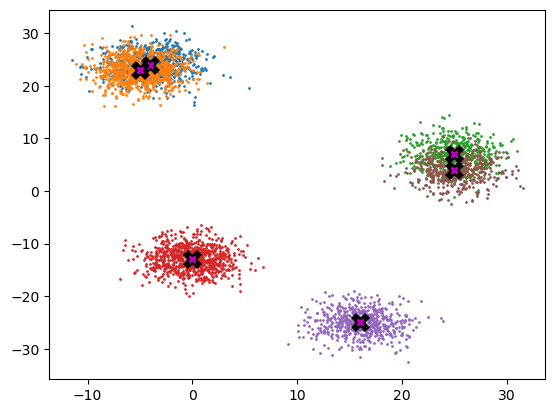

In [35]:
plot_data(centroids, data, labels)

In [36]:
midp = data.mean(0)
midp

tensor([6.673, 4.344])

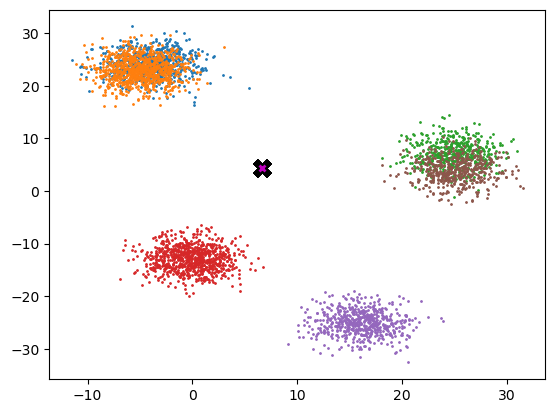

In [37]:
plot_data([midp]*6, data, labels)

## [Mean shift](https://en.wikipedia.org/wiki/Mean_shift) Algorithm

In the clustering problem, the centroids are not given, we need to find them. <br>
Mean shift is a procedure for locating the maxima—the modes—of a density function given discrete data sampled from that function.

Most known clustering algorithm is **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

The definition of the gaussian kernel:
$$f(x) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$$
or 
$$g(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{1}{2} \frac{(x - \mu)^2}{\sigma^2} \right)$$
Below: $\sigma$ = `bw`    and   $(x - \mu) =$ `d`

Mean Shift is a good clustering approach, we don't have to say how many clusters there are.
Other algorithms, e.g., *k-means* require us to say how many. 
Instead, we just have to pass a bandwidth which can be chosen automatically.
It can also handle clusters of any shape, they don't have to be ball-shaped.
<br>
We're going to pick a point, and find the distance between that point and every other point in a big list. 
Now we take a weighted average of all of those points, such that
a point that is a very close (far) from our point of interest should have a very high (low) weight.
A Gaussian kernel creates weights for every point compared to the one that we're currently interested in using.
Points that are further away are penalized, at a rate determined by the bandwidth,  
which is the standard deviation of our Gaussian. 
The weighted average is mainly going to be a weighted average of the points that are nearby. 
And the weighted average of those points, is going to move all of these points in closer, like a gravitational center. 

In [13]:
import math
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

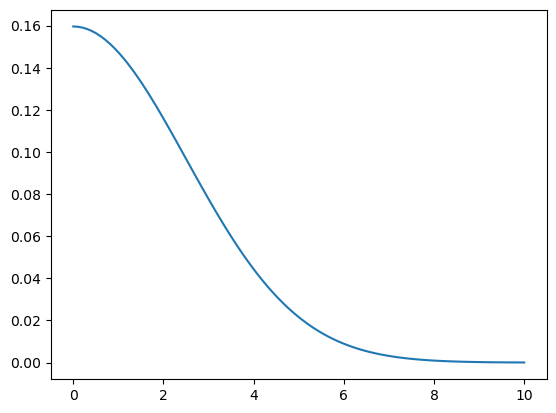

In [14]:
#x indicates the distance from a point.
x = torch.linspace(0,10,100)
plt.plot(x, gaussian(x,2.5), label='Gaussian');

It is helpful to have something that can quickly plot any function. 
It doesn't come with Matplotlib, lets write it. 
For X, let's use all the numbers from 0 to 10, 100 of them spaced evenly. 
That's what linspace() does, linearly spaced 100 numbers in this range. 
We plot those Xs and plot f(X), the Ys in `plot_func` we want. 

In [15]:
#Alternative using partial
from functools import partial

def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

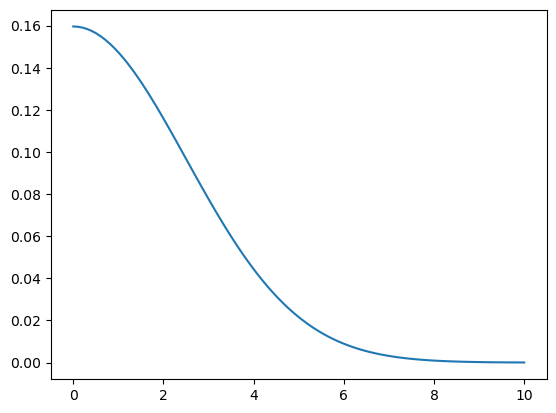

In [16]:
plot_func(partial(gaussian, bw=2.5))

With partial we define a new function, here is the function Gaussian, and is going to automatically pass bw equals 2.5. 
This is a partially applied function.  We use partial function application a lot, it is a very important tool. 
Without it plotting this function would have been more  complicated. 

In [17]:
f = partial(gaussian, bw=2.5)

So f(tensor(4)), is just like the graph, about 0.44. 

In [18]:
f(tensor(4))

tensor(0.044)

An alternative would be to create an inline function using lambda. 

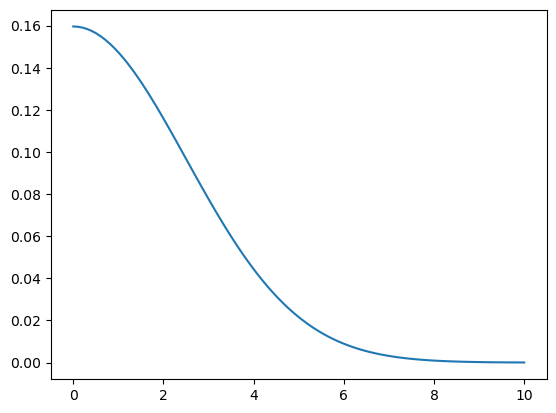

In [19]:
plot_func(lambda x: gaussian(x, bw=2.5))

We managed to plot this function for a bandwidth of 2.5, using functools `partial`. 
To find out where something comes from, just to type it and press shift enter, and it'll tell you where it comes from. 
And you can get its help with question mark, and we can get it source code with two question marks. 
n application. 

In [20]:
partial

functools.partial

We choose the bandwidth to be 2.5. 
One easy way to choose bandwidth is to find which bandwidth covers about one third of the data.

Often when we see something that is on the complicated side, like a Gaussian, we can often simplify things. 
If we look at the shape, it looks a lot like the shape of a triangular weighting, which is just using a linear with `clamp_min()`. 
We probably can use this just as well, so we define `tri()` and then we can try both. 

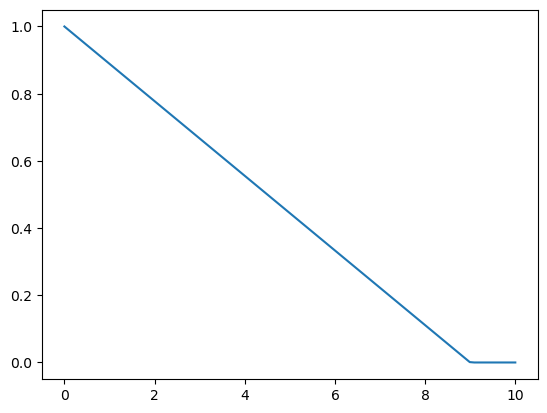

In [21]:
#Alternative function that is simpler and very similar
def tri(d, i): return (-d+i).clamp_min(0)/i
plot_func(partial(tri, i=9))

We start with the Gaussian version, and move all the  points towards their "center of gravity". 
We don't want to mess up our original data, so we clone it with `torch.clone()`.
`X` is our matrix of data, `x` is our first point.

In [22]:
X = data.clone() # Data
x = data[0]  # first point
x

tensor([26.204, 26.349])

`x` is our first point, a rank-1 tensor of shape 2.
`X` is a rank-2 tensor of 1,500 data points by 2, the x and y. 

In [23]:
x.shape, X.shape

(torch.Size([2]), torch.Size([4029, 2]))

We want to find the distance from `x` to everything in `X`.
We got shapes of different lengths, we can use the shorter length and
it's going to add unit axes to the front to make it as long as necessary.
It works as the dimension is compatible, we go right to left, the last axes match.
If an axis doesn't exist, it pretends that there is a unit axis. 

In [24]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

We get the distances on each coordinate, between our first point x and all of the other points in the data. 
Just looking at the first eight of them here. 
The first distance is zero on both axes as it is the first point. 
Because of the way we created the clusters, the data of the first cluster is all next to each other in the list,
none are too far away from each other. 

Now that we've got all the X and Y distances, it's easy to get the Euclidean distance: 
square that difference and sum, and square root. 

In [25]:
Edist = ((x-X)**2).sum(1).sqrt()
Edist

tensor([ 0.000,  3.899,  4.834,  ..., 20.737, 24.496, 24.511])

In [26]:
def tdist(x, X):
    return ((x-X)**2).sum(1)

def edist (x, X):
    return ((x-X)**2).sum(1).sqrt()

In [27]:
# the distance of x to every point in X with different norms
%time t = tdist(x, X)
%time e = edist(x, X)
t[:8], e[:8]

CPU times: user 2.8 ms, sys: 407 µs, total: 3.21 ms
Wall time: 498 µs
CPU times: user 3.51 ms, sys: 1.31 ms, total: 4.82 ms
Wall time: 864 µs


(tensor([ 0.000, 15.199, 23.369, 13.887, 39.350, 16.993, 43.031, 36.020]),
 tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002]))

In [38]:
dist = t
t.shape

torch.Size([4029])

In [29]:
#TODO HW: Rewrite using torch.einsum
v = x - X
%time d2 = torch.einsum('ij,ij->i',v,v)
%time e2 = torch.einsum('ij,ij->i',v,v).sqrt()
d2[:8], e2[:8]

CPU times: user 1.51 ms, sys: 392 µs, total: 1.9 ms
Wall time: 324 µs
CPU times: user 3.2 ms, sys: 1.39 ms, total: 4.6 ms
Wall time: 771 µs


(tensor([ 0.000, 15.199, 23.369, 13.887, 39.350, 16.993, 43.031, 36.020]),
 tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002]))

In [30]:
#TODO HW: Rewrite using torch.einsum
%time dist2 = torch.einsum('ij,ij->i',(x-X),(x-X))
dist2[:8]

CPU times: user 3.14 ms, sys: 984 µs, total: 4.12 ms
Wall time: 833 µs


tensor([ 0.000, 15.199, 23.369, 13.887, 39.350, 16.993, 43.031, 36.020])

In [39]:
from fastcore.test import test_close
test_close(dist, dist2)

## Compute Weights
Now we can get the weights by passing the distances to our Gaussian. 
The biggest weight is up to 0.16, the closest one is itself.
The other ones get reasonable weights and the data points that are in totally different clusters
have weights small enough that at three significant figures they appear to be 0. 

In [40]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.000,     0.000,  ...,     0.000,     0.000,     0.000])

In [41]:
weight.shape,X.shape

(torch.Size([4029]), torch.Size([4029, 2]))

### Extra stuff
Let's take a look at how the distances and weights to the first point are distributed:

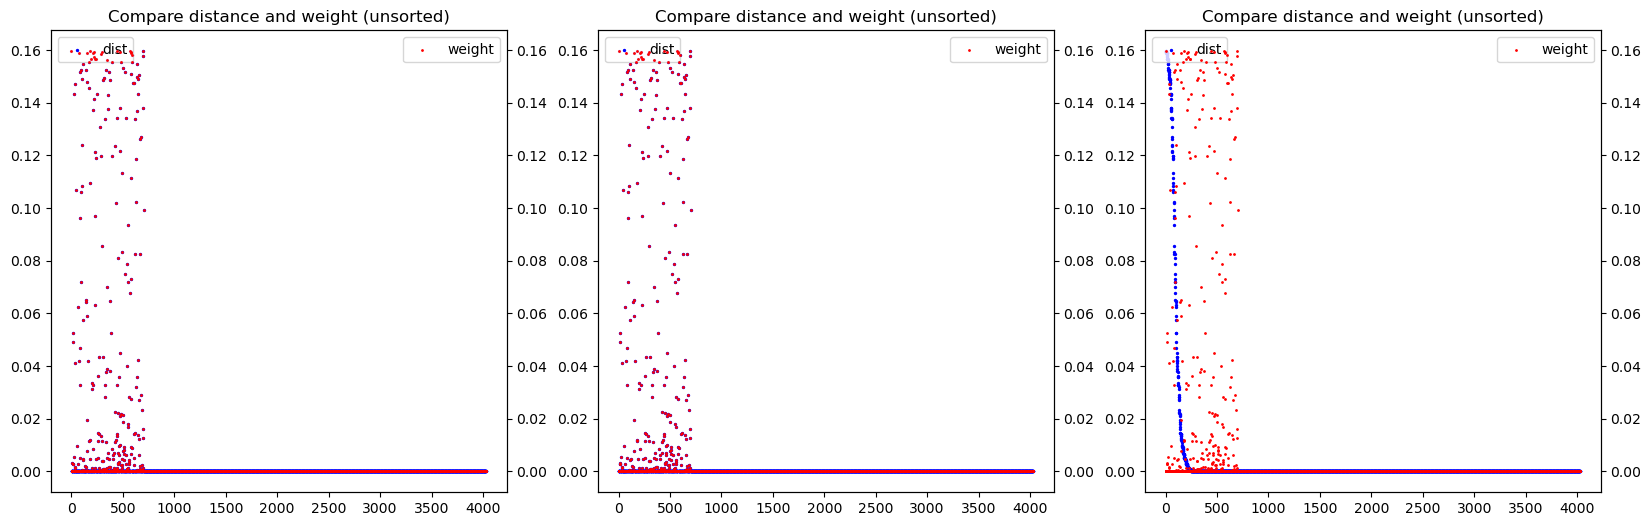

In [42]:
plt.figure(figsize=(20,6))

fs = [weight, weight[labels.argsort()], weight[dist.argsort()]]

for i in range (1,4):
    plt.subplot(1,3,i)
    plt.scatter(range(len(weight)),fs[i-1],color='b',s=2,label='dist')
    plt.legend(loc='upper left')
    plt.gca().twinx().scatter(range(len(weight)),weight,color='r',s=1,label='weight')
    plt.legend(loc='upper right')
    plt.title('Compare distance and weight (unsorted)')

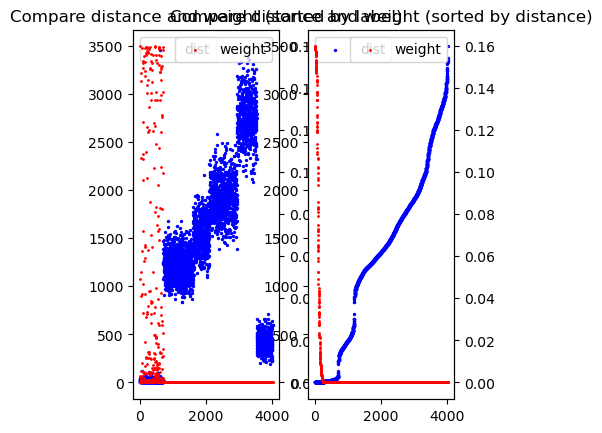

In [43]:
plt.subplot(1,3,2)
plt.scatter(range(len(weight)),dist[labels.argsort()],color='b',s=2,label='dist')
#plt.ylabel('dist')
plt.legend(loc='upper left')
plt.gca().twinx().scatter(range(len(weight)),weight[labels.argsort()],color='r',s=1,label='weight')
#plt.ylabel('weight')
plt.legend(loc='upper right')
plt.title('Compare distance and weight (sorted by label)')

plt.subplot(1,3,3)
plt.scatter(range(len(weight)),dist[dist.argsort()],color='b',s=2,label='dist')
#plt.ylabel('dist')
plt.legend(loc='upper left')
plt.gca().twinx().scatter(range(len(weight)),weight[dist.argsort()],color='r',s=1,label='weight')
#plt.ylabel('weight')
plt.legend(loc='upper right')
plt.title('Compare distance and weight (sorted by distance)');

We now want a weighted average
Formally, the weighted mean of a non-empty finite tuple of data $$\left( x_1, x_2, \dots , x_n \right)$$
with corresponding non-negative weight function|weights $$( w_1, w_2, \dots , w_n)$$ is
$$\bar{x} = \frac{ \sum\limits_{i=1}^n w_i x_i}{\sum\limits_{i=1}^n w_i}$$
which expands to:
$$\bar{x} = \frac{w_1 x_1 + w_2 x_2 + \cdots + w_n x_n}{w_1 + w_2 + \cdots + w_n}.$$

Need to add a trailing axis to the weights to be able to multiply

In [44]:
(weight[:,None]*X)

tensor([[    4.182,     4.205],
        [    0.000,     0.000],
        [    0.000,     0.000],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [45]:
(weight[:,None]*X).sum(0)/weight.sum()

tensor([26.329, 26.854])

Now all together in a single cell for a single update.

In [46]:
def one_update(X):
    for i, x in enumerate(X):
        #dist = torch.sqrt(((x-X)**2).sum(1))
        dist = torch.einsum('ij,ij->i',(x-X), (x-X)).sqrt()
        #weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [47]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [48]:
%time X=meanshift(data)

CPU times: user 18 s, sys: 473 ms, total: 18.4 s
Wall time: 3.14 s


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

In [49]:
n_samples = labels

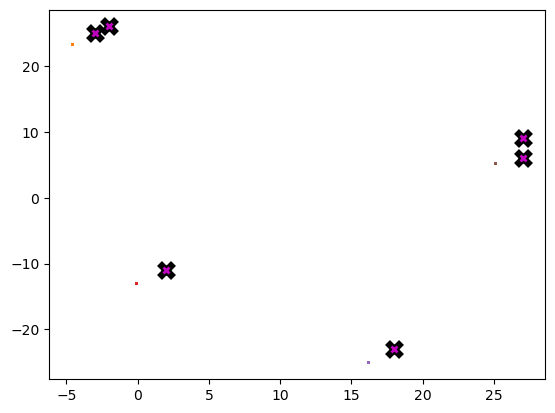

In [50]:
plot_data(centroids+2, X, labels) #n_samples)

All the computation is happening in the <tt>for</tt> loop, which isn't accelerated by pytorch. Each iteration launches a new cuda kernel, which takes time and slows the algorithm down as a whole. Furthermore, each iteration doesn't have enough processing to do to fill up all of the threads of the GPU. But at least the results are correct...

We should be able to accelerate this algorithm with a GPU.

## Animation

In [51]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [52]:
def do_one(d):
    if not d: return plot_data(centroids+2, X, n_samples, ax=ax)
    one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [53]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

**Homework:**
implement [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering), [dbscan](https://en.wikipedia.org/wiki/DBSCAN), 
[locality sensitive hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing), 
or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. 
Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super Bonus: Invent a new meanshift algorithm which picks only the closest points to avoid quadratic time.
SB+: Publish it!


# Meanshift with bias and random sampling

In [54]:
def tri_with_bias(d, i): return (-d+i).clamp_min(0)/i + 0.0001
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [55]:
# This is more or less the same definition used in lesson 12 expect batching has been removing
def vanilla_meanshift(data):
    X = data.clone()
    for it in range(5):
        weight = tri_with_bias(dist_b(X, X), 8)
        div = weight.sum(1, keepdim=True)
        X = weight@X/div
    return X

In [56]:
n_datapoints = len(X)

In [57]:
def meanshift_with_random_sampling(data, n=5, rs=n_datapoints):
    X = data.clone()
    for it in range(5):
      rdx = torch.randint(0, X.shape[0], (rs,))
      X_rand = X[rdx] 
      dist = ((X.unsqueeze(1) - X_rand.unsqueeze(0))**2).sum(2).sqrt()
      w = tri_with_bias(dist, 8)
      w_norm = w/w.sum(1, keepdim=True)
      X = (X_rand.unsqueeze(0) * w_norm.unsqueeze(-1)).sum(1)
    return X

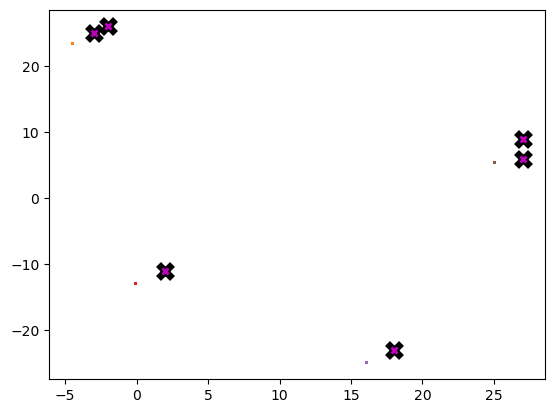

In [58]:
plot_data(centroids+2, vanilla_meanshift(data).cpu(), n_samples, ax=None)

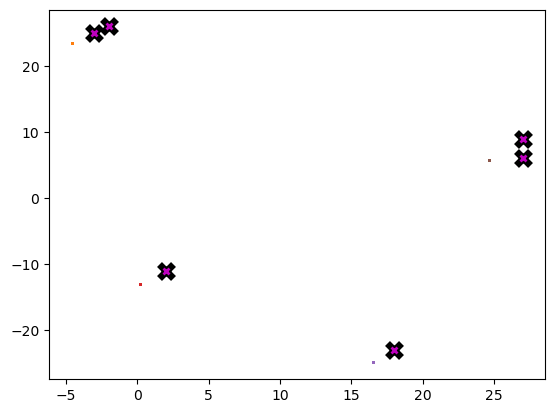

In [59]:
plot_data(centroids+2, meanshift_with_random_sampling(data, n=5, rs=int(0.05*n_datapoints)).cpu(), n_samples, ax=None)

## Performance

In [60]:
%time vanilla_meanshift(data)

CPU times: user 5.9 s, sys: 1.02 s, total: 6.92 s
Wall time: 1.21 s


tensor([[-4.540, 23.457],
        [-4.540, 23.457],
        [-4.540, 23.457],
        ...,
        [24.977,  5.503],
        [24.977,  5.503],
        [24.977,  5.503]])

In [61]:
%time meanshift_with_random_sampling(data, n=5, rs=int(0.05*n_datapoints))

CPU times: user 304 ms, sys: 37.1 ms, total: 341 ms
Wall time: 59 ms


tensor([[-4.780, 24.002],
        [-4.780, 24.002],
        [-4.780, 24.002],
        ...,
        [25.189,  6.002],
        [25.189,  6.002],
        [25.189,  6.002]])

In [62]:
%timeit -n 5 -r 10 -o vanilla_meanshift(data) #.cpu()

1.07 s ± 68 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 1.07 s ± 68 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)>

In [63]:
%timeit -n 5 -r 10 -o meanshift_with_random_sampling(data, n=5, rs=int(0.05*n_datapoints)) #.cpu()

50.6 ms ± 10 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


<TimeitResult : 50.6 ms ± 10 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)>

Let's see how the performance varies based on the number of random samples k

In [64]:
n_random_samples = torch.linspace(50, n_datapoints, 30)

In [65]:
avg_run_times = []
for n in n_random_samples:
  result = %timeit -n 5 -r 100 -o meanshift_with_random_sampling(data, n=5, rs=int(n.item())).cpu()
  avg_time_in_ms = round(1000*result.average, 2)
  avg_run_times.append(avg_time_in_ms)

12.8 ms ± 2.5 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
50.5 ms ± 6.49 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
97.4 ms ± 14.1 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
132 ms ± 13.3 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
158 ms ± 14.1 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
193 ms ± 16.2 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
266 ms ± 20 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
319 ms ± 33.6 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
348 ms ± 36.2 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
385 ms ± 26.3 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
417 ms ± 26.1 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
461 ms ± 26.5 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
506 ms ± 33.5 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
531 ms ± 27 ms per loop (mean ± std. dev. of 100 runs, 5 loops each)
586 ms ±

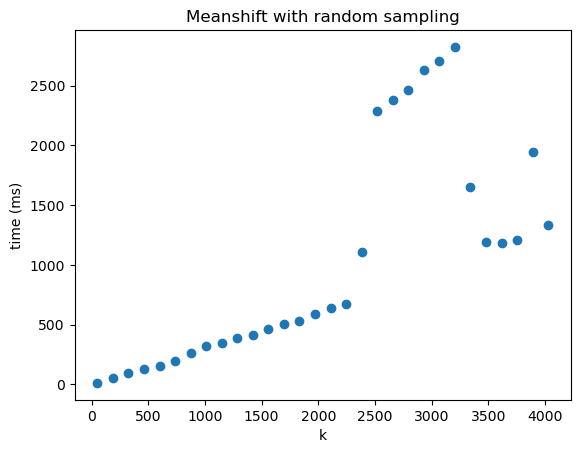

In [66]:
fig, ax = plt.subplots()
ax.scatter(n_random_samples, avg_run_times)
plt.xlabel('k')
plt.ylabel('time (ms)')
plt.title('Meanshift with random sampling')
plt.savefig('meanshift_with_random_sampling_timing_data.png')

In [67]:
STOP: no GPU

SyntaxError: invalid syntax (4015990691.py, line 1)

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [ ]:
def dist_b(a,b): return torch.sqrt(((a[None]-b[:,None])**2).sum(2))

In [ ]:
X=torch.rand(8,2)
x=torch.rand(5,2)
dist_b(X, x)

In [ ]:
bs=5
X = data.clone()
x = X[:bs]
weight = gaussian(dist_b(X, x), 2)
weight

In [ ]:
weight.shape,X.shape

In [ ]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

In [ ]:
div = weight.sum(1, keepdim=True)
div.shape

In [ ]:
num/div

In [ ]:
from fastcore.all import chunked

In [ ]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = (weight[...,None]*X[None]).sum(1)
            div = weight.sum(1, keepdim=True)
            X[s] = num/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [ ]:
data = data.cuda()

In [ ]:
X = meanshift(data).cpu()

In [ ]:
%timeit -n 1 X = meanshift(data).cpu()

In [ ]:
plot_data(centroids+2, X, n_samples)